# Libaries to import 

In [1]:
from audioFunctions import *
from binaryFunctions import *
from qam import *
from sequenceGenerators import *
from receiver import *
from error_coding import *
from to_import import *

# Transmitsion
### Importing data, preparing them into the relevant formats, and saving/playing the output .wav file

In [2]:
# Load data here

# Random bits 
CE_binary = binaryTextFileToBinary('Data_Files/random_bits.txt')

# Original binary file
binary = binaryTextFileToBinary('Data_Files/kokoro_bin.txt')

In [3]:
# Error coding here

# Original binary file passed through Hamming(7,4) coding
coded_binary = binaryTextFileToBinary('Data_Files/coded_kokoro_bin.txt')

In [4]:
# Set the parameters for transmission
Mode = "C" # select mode from A, B, C

# Cyclic Prefix
CP_mode = {"A": 224, "B": 704, "C": 1184}

# DFT length 
N = 4096
CP = CP_mode[Mode]

# Number of time indecies we go back in time from the "optimal point"
guard = 5

# Number of known symbol repeats for every frame
CE_repeat = 20

# Number of data symbols in each frame
frame_data_length = 180

In [5]:
# Make your instructions ( THIS CAN BE MADE MORE COMPLICATED USING MAGNITUDE DATA FROM THE CHANNEL TF )
instruction = []
for i in range(int(N/2 - 1)):
    if i <1499 and i >= 99:
        instruction.append(1)
    else: 
        instruction.append(0)
        
# assuming 0 -> no data, 1 -> QPSK, 2 -> 16QAM
# find number of bits necessary for each OFDM symbol 
bits_in_ofdm_symbol = 0
for value in instruction: 
    bits_in_ofdm_symbol += value*2

In [6]:
# XOR operation

# This is information shared to the receiver
rand_binary = CE_binary[:bits_in_ofdm_symbol]  
data_binary_len = len(coded_binary)

# Not shared to receiver
rand_for_xor = (rand_binary * math.ceil(data_binary_len/bits_in_ofdm_symbol))[0:data_binary_len]

# XOR the coded binary sequence
coded_binary = xor(coded_binary, rand_for_xor)

print(len(rand_binary), bits_in_ofdm_symbol)

2800 2800


In [7]:
# QAM modulation for the coded binary sequence

# Modulate the random sequence used for channel estimation using QPSK
CE_modulated = qpsk(CE_binary)
#CE_modulated = varyingModulation_std(CE_binary, instruction, N, CE_binary, print_progress = True, max_odfm_symbol =1)

# Modulate the data symbols using the instruction array
data_modulated = varyingModulation_std(coded_binary, instruction, N, CE_binary, print_progress = True)

bitcount 2800
additional  2380
data length  5580820
new data len  5583200
symbol number 100 is done.
symbol number 200 is done.
symbol number 300 is done.
symbol number 400 is done.
symbol number 500 is done.
symbol number 600 is done.
symbol number 700 is done.
symbol number 800 is done.
symbol number 900 is done.
symbol number 1000 is done.
symbol number 1100 is done.
symbol number 1200 is done.
symbol number 1300 is done.
symbol number 1400 is done.
symbol number 1500 is done.
symbol number 1600 is done.
symbol number 1700 is done.
symbol number 1800 is done.
symbol number 1900 is done.


In [8]:
print(CE_modulated[95:105])

[-0.70710678-0.70710678j  0.70710678-0.70710678j  0.70710678+0.70710678j
 -0.70710678-0.70710678j -0.70710678-0.70710678j -0.70710678-0.70710678j
 -0.70710678+0.70710678j  0.70710678-0.70710678j -0.70710678+0.70710678j
 -0.70710678-0.70710678j]


In [9]:
# Chirp signal 
Start_F = 0
End_F = 8000
Time = 5*(CP+N)/fs

# Prepare chirp signal
chirp_signal = Chirp(Start_F,End_F,Time, volume = 100)

In [10]:
# For channel esimation (CE)

# Prepare CE and payload data to be transmitted
CE_symbols, CE_Freq = ofdmSymbols(CE_modulated, CP, N)
Payload_symbols, Payload_Freq = ofdmSymbols(data_modulated, CP, N)

# Adjust the number of OFDM symbols in the payload so it has intger number of frame content
extra = frame_data_length - len(Payload_symbols)%frame_data_length
for i in range(extra):
    Payload_symbols = np.concatenate((Payload_symbols, [CE_symbols[1]]))
    

# Identify number of frames are present in the transmitted sequence
num_of_frames = int(len(Payload_symbols)/frame_data_length)

In [11]:
# Prepare what to actually transmit

# Channel estimation at the beginning
CE_transmit = repeat_signal(CE_symbols[0], CE_repeat)
known_freq = CE_Freq[0]

# Payload mixed with CE symbols distributed between them
Payload = prepare_payload_std(Payload_symbols, CE_transmit, chirp_signal, num_of_frames, frame_data_length)

In [12]:
Tx = (Pause(1),) + tuple(Payload) # Pause 20 is just to remove any effects a the beginning of the transmission 
Transmit_time = round(len(np.concatenate(Tx))/fs, 2)

print("Transmit signal is", math.floor(Transmit_time/60), "min and", Transmit_time%60, "seconds")

Transmit signal is 4 min and 58.0 seconds


In [13]:
# Transmit the message / save the wav file
# playOutput = True to play the wave file 
x = save_transmit( Tx , playOutput=False)

# Receiver

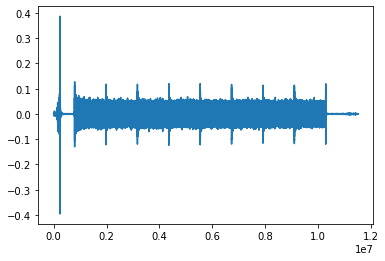

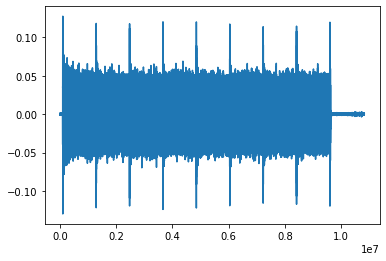

In [14]:
# Import the recorded signal
y = audioDataFromFile('Wav_Files/other_grp/group4-C2.wav')
plot_y(y)

# Find the first chirp and return the signal from just before that chirp
y_signal = detect_chirps(y, chirp_signal, 60)
plot_y(y_signal, f=1)

In [15]:
def count_frames_test(y_next, h, length):
    i = 0
    count = 1
    while 1:
        portion = y_next[:fs*5]
        g = np.convolve(portion, h[::-1], 'valid')
        max_value = max(g)
        
        print(np.argmax(g), i)

        if i == 0:
            compare = max_value
        else:
            if max_value > compare * 0.2: 
                count += 1
            else:
                break

        y_next = y_next[length:]
        if len(y_next) < len(h)*2:
            break

        i += 1

    return count

    
length = (N + CP) * (frame_data_length + CE_repeat * 2) + len(chirp_signal)
frame_count = count_frames_test(y_signal, chirp_signal, length)#-1

96002 0
96002 1
96003 2
96004 3
96005 4
96006 5
96007 6
96008 7
96008 8
38298 9


In [16]:
# length of each frame in time steps
length = (N + CP) * (frame_data_length + CE_repeat * 2) + len(chirp_signal)
frame_count = count_frames_test(y_signal, chirp_signal, length)
print(frame_count)

96002 0
96002 1
96003 2
96004 3
96005 4
96006 5
96007 6
96008 7
96008 8
38298 9
9


Completed frame 1
   Linear phase gradient was  -0.013291279675810478
Data slicing complete


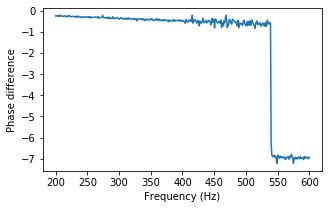

In [25]:
#################################################################################################
# TUNABLE PARAMETERS!
#################################################################################################

stable_phase_start = 200     # where we estimate the "stable region" of the phase to start
stable_phase_length = 400    # how long the stable region continues for
plot = True                # display plots or not

#################################################################################################


# Calculating time index lengths
data_index_length = frame_data_length * (N+CP)
CE_index_length = CE_repeat * (N+CP)


y_use = y_signal
# big loop to find out everything
for i in range(frame_count-1):
    
    # obtain only the time series for one frame
    y_data = removeChirpAndPause_std(y_use, chirp_signal, fs*6, plot = False, rng = 100)
    


    # Slice the data to retrieve the CE
    CE_samples, CE_freq, remaining = sliceData(y_data, CP-guard, N, CP, CE_repeat)
    CE_samples_end, CE_freq_end, remaining_end \
                    = sliceData(y_data[data_index_length + CE_index_length:], CP-guard, N, CP, CE_repeat)
    
    
    # Obtain channel response at the beginning and end of the frame
    # channel response -> Impulse response and Frequency response (Transfer function)
    impulse_start, TF_start = getTF_FreqAverage(CE_freq, known_freq, N, CE_repeat)
    impulse_end, TF_end = getTF_FreqAverage(CE_freq_end, known_freq, N, CE_repeat)


    # Unwrapped phase for positive frequencies of the channel response
    angle_start = np.unwrap(np.angle(TF_start[:2048]))
    angle_end = np.unwrap(np.angle(TF_end[:2048]))

    # Difference in phase 
    difference = []
    for p, val in enumerate(angle_end):
        difference.append(round(val - angle_start[p], 3))
        
    # p = x coordinates, q = y coordinates to do linear curve fitting
    p = np.linspace(stable_phase_start,   stable_phase_start + stable_phase_length,   stable_phase_length)
    q = difference[stable_phase_start:   stable_phase_start + stable_phase_length  ]
    
    # output gradient and y-intercept. 
    param = np.polyfit(p,q,1)
    grad = param[0]
    
    # Organise all the data symbols in the frame into chunks of 2047 frequency bins
    # Also perform phase correction using the gradient of the linear phase added due to the frequency mismatch
    sliced_data = sliceDataContent_std(TF_start, TF_end, remaining, CP-guard, N, CP, frame_data_length, 0, CE_repeat)
    if i == 0:
        freq_data = sliced_data
    else:
        freq_data = np.concatenate((freq_data, sliced_data))
    
    
    # Update the time domain signal for the next frame
    y_use = remaining_end
    
    
    print("Completed frame " + str(i+1))
    print("   Linear phase gradient was ", grad)
    
    
    # plotting stuff for debug purposes
    if plot:  
        '''
        plot_y(difference[stable_phase_start:stable_phase_length + stable_phase_start], f = i+100, title = "difference " + str(i+1))
        plot_y(angle_start, f = i, title = "Phase of positive frequencies. Frame " + str(i+1))
        plot_y(angle_end, f= i)
    
    
        plt.figure(i+1000)
        plt.yscale("log")
        plt.plot(abs(np.array(TF_start))[:2048])
        plt.plot(abs(np.array(TF_end))[:2048])
        plt.title("Log magnitude plot. Frame " + str(i+1))
        plot_y(abs(np.array(TF_start))[:2048], f=i+2000, title = "Linear magnitude plot. Frame " + str(i+1)) 
        '''
        fq = np.linspace(stable_phase_start, stable_phase_start + stable_phase_length, stable_phase_length)
        plt.figure(9, figsize = (5,3))
        plt.plot(fq, difference[stable_phase_start:stable_phase_length + stable_phase_start])
        plt.ylabel("Phase difference")
        plt.xlabel("Frequency (Hz)")
        plt.savefig("Data_Files/grp4incorrect.pdf")


    break
print("Data slicing complete")
#print("A total of " + str(freq_data.shape[0]) + " OFDM symbols")

In [19]:
from sklearn.cluster import KMeans
def find_angle_offset_test(a, disp = False):

    b = [[None]] * len(a)
    mag = []
    for i in range(len(a)):
        mag.append(abs(a[i]))
        if abs(a[i]) < 5:
            b[i] = [a[i].real, a[i].imag]
        else:
            b[i] = [a[i].real/abs(a[i]), a[i].imag/abs(a[i])]


    kmeans = KMeans(n_clusters=4, random_state=0).fit(b)

    cent = kmeans.cluster_centers_

    #x,y = np.split(cent, 2,axis = 1)
    #plt.scatter(x, y)


    angle = []
    for i in range(4):
        angle.append(np.angle(cent[i][0] + cent[i][1]*1j))
    
    angle = np.array(angle)

    
    ## this depends on the data but for now we penalise everything with greater abs phase than pi/4
    angle2 = angle
    for i in range(len(angle2)):
        if abs(angle2[i]) > math.pi*(7/18):
            angle2[i] += 100
    
    #c = abs(angle - np.ones(angle.shape)*(math.pi/4))
    c = abs(angle2 - np.ones(angle.shape)*(math.pi/4))
    
    output =  math.pi/4 - angle2[c.argmin()]
    
    if disp:
        print(angle, c, c.argmin(), output,end = '\n\n')
        print(cent)
        #print(angle[np.abs(angle - math.pi/4).argmin()])
        #print("closest to pi/4", angle[c.argmin()])

    return output 

In [21]:
phase = 0
batch = 10
window = 1.7


corrected_freq_data = []
index = 1
strt = 180*3
oldphase = 0
for i in range(len(freq_data)):#strt, strt+180):#180*index,180*(index+1)):
    symb = freq_data[i]
    

    phase = find_angle_offset_test(symb[99:1499], disp = False)
    
    if i%180 > 5:
        if (phase/oldphase < 1/3 or phase/oldphase > 3) and oldphase != 0:
            phase = oldphase
        
    oldphase = phase
    
    for j in range(len(symb)):
        symb[j] *= cmath.rect(1, phase*j*(1/700))
        
        
    phase2 = 0   
    if i%180 > 100 or 1:

        phase2 = find_angle_offset_test(symb[99:1499])#, disp = True)    
        #print("phase", phase, phase2)

        for j in range(len(symb)):
            symb[j] *= cmath.rect(1, phase2*j*(1/700))

    
    #print("phase", phase, phase2, i)

    corrected_freq_data.append(symb)
    
    '''
    plot_res = np.array(symb)[99:1499]
    plt.figure(i+2000)
    plt.scatter(plot_res.real, plot_res.imag,s=0.1)
    plt.title(i)
    plt.xlim(-1*window,window)
    plt.ylim(-1*window, window)
    
    
    for j in range(len(symb)):
        symb[j] *= cmath.rect(1, -1*phase2*j*(1/700))
        
    for j in range(len(symb)):
        symb[j] *= cmath.rect(1, -1*phase*j*(1/700))

    '''
    if i%50 == 0:
        print(i, "th symbol done")


0 th symbol done
50 th symbol done
100 th symbol done
150 th symbol done
200 th symbol done
250 th symbol done
300 th symbol done
350 th symbol done
400 th symbol done
450 th symbol done
500 th symbol done
550 th symbol done
600 th symbol done
650 th symbol done
700 th symbol done
750 th symbol done
800 th symbol done
850 th symbol done
900 th symbol done
950 th symbol done
1000 th symbol done
1050 th symbol done
1100 th symbol done
1150 th symbol done
1200 th symbol done
1250 th symbol done
1300 th symbol done
1350 th symbol done
1400 th symbol done


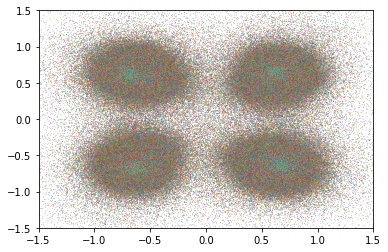

In [22]:
# Plot constellations to see if they are sensible. 


# Set which OFDM symbol to view
start = 0
duration = 180*8

# display window size
window = 1.5

for i in range(duration):
    
    plot_res = np.array(corrected_freq_data[start+i])[100:1500]
    plt.scatter(plot_res.real, plot_res.imag, s = 0.01)
    plt.xlim(-1*window,window)
    plt.ylim(-1*window, window)

In [67]:
corrected_freq_data[0][100:104]

array([ 0.70402415-0.56110997j, -0.68856785+0.69491404j,
       -0.60008659+0.55925027j, -0.4624312 +0.67169828j])

In [70]:
demodulated_data[:8]

'10100101'

In [29]:
demodulated_data = demodVaryingModulation_std(np.concatenate(tuple(corrected_freq_data)), instruction, N)

# This is information shared to the receiver
data_binary_len = len(demodulated_data)

# What to xor with the data. rand_binary calculated in Transmission side. 
rand_for_xor_Rx = (rand_binary * math.ceil(data_binary_len/bits_in_ofdm_symbol))[0:data_binary_len]


In [30]:
# XOR the whole sequence
predict = xor(demodulated_data, rand_for_xor_Rx)

In [31]:
Filename, Length, data_bits = remove_metadata(predict)
print(Filename, Length)

Group4-C1.wav 479232


In [32]:
new_data = []
for i in range(0, len(data_bits), 16):
    new_data.append(data_bits[i:i+16])  

int_data = [] 
for i in new_data:
    int_data.append(int(i,2)-2**15)

scipy.io.wavfile.write("Data_Files/grp4.wav", 
48000, np.array(int_data, dtype = np.int16))

In [46]:
check_binary = binaryTextFileToBinary('Data_Files/xor_binary.txt')

In [47]:
correct = 0
max_index = min(len(predict), len(check_binary)-2)
for i in range(max_index):
    if predict[i] == check_binary[i+2]:
        correct += 1
    else:
        pass #print(predict[i], check_binary[i+2])
        
print(correct, max_index)
print('\n',correct/max_index)

1918094 3833854

 0.5003043934380391


In [50]:
print(check_binary[:80])
print(predict[:80])

01100010001110100000110111000100110101000010110110101001010010000110000101010111
00000000000011100000000000101101000000000110000100000000010100100000000010100110


In [315]:
print(predict[:10])

0000000000
